In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1 

In [2]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [3]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [4]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [25]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(SGDClassifier(),
                 dict(loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                       penalty = ['l2', 'l1', 'elasticnet']),
                 cv = skf,
                 scoring = my_custom_score),    
]           
                 
                 
iterations = 10                
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(SGDClassifier(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations)
]

In [23]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [24]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


# Scaling is not relevant for Decision Trees
for data_preparation_strategy in range(1,5):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 1 features after 1.06 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 2 features after 1.11 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 3 features after 1.12 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 4 features after 1.18 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 5 features after 1.1 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 6 features after 1.2 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 7 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 8 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 9 features after 1.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 10 features after 1.28 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 11 features after 1.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 12 features after 1.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 13 features after 1.29 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 14 features after 1.22 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 15 features after 1.62 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 16 features after 1.58 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 17 features after 1.57 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 18 features after 1.75 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 19 features after 1.55 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with No Scaling and 20 features after 1.61 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 1 features after 1.11 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 2 features after 1.12 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 3 features after 1.11 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 4 features after 1.21 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 5 features after 1.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 6 features after 1.13 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 7 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 8 features after 1.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 9 features after 1.17 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 10 features after 1.18 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 11 features after 1.31 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 12 features after 1.17 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 13 features after 1.25 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 14 features after 1.22 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 15 features after 1.48 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 16 features after 1.59 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 17 features after 1.57 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 18 features after 1.34 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 19 features after 1.39 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with MinMaxScaler and 20 features after 1.69 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 1 features after 1.05 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 2 features after 1.12 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 3 features after 1.19 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 4 features after 1.11 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 5 features after 1.15 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 6 features after 1.24 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 7 features after 1.13 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 8 features after 1.13 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 9 features after 1.18 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 10 features after 1.24 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 11 features after 1.22 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 12 features after 1.27 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 13 features after 1.19 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 14 features after 1.19 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 15 features after 1.59 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 16 features after 1.5 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 17 features after 1.56 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 18 features after 1.68 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 19 features after 1.7 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with StandardScaler and 20 features after 1.66 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 1 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 2 features after 1.1 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 3 features after 1.12 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 4 features after 1.15 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 5 features after 1.23 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 6 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 7 features after 1.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 8 features after 1.23 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 9 features after 1.25 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 10 features after 1.2 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 11 features after 1.28 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 12 features after 1.23 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 13 features after 1.23 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 14 features after 1.33 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 15 features after 1.6 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 16 features after 1.49 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 17 features after 1.67 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 18 features after 1.62 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SGDClassifier with LogScaler and 19 features after 1.73 seconds
Finished SGDClassifier with LogScaler and 20 features after 1.73 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
63,SGDClassifier,LogScaler,4,"[trustLevel, scannedLineItems, pricePerScanned...","{'learning_rate': 'optimal', 'loss': 'perceptr...",-0.204896,0.166213,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
41,SGDClassifier,StandardScaler,2,"[trustLevel, scannedLineItems]","{'learning_rate': 'optimal', 'loss': 'squared_...",-0.239489,0.158602,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
0,SGDClassifier,No Scaling,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
20,SGDClassifier,MinMaxScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
60,SGDClassifier,LogScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
40,SGDClassifier,StandardScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'log', 'p...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
19,SGDClassifier,No Scaling,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'perceptr...",-0.284726,0.050961,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
59,SGDClassifier,StandardScaler,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'hinge', ...",-0.290048,0.038596,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
64,SGDClassifier,LogScaler,5,"[trustLevel, lineItemVoidsPerPosition, scanned...","{'learning_rate': 'optimal', 'loss': 'modified...",-0.292709,0.204675,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
79,SGDClassifier,LogScaler,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'log', 'p...",-0.303353,0.049882,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest


In [26]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
63,SGDClassifier,LogScaler,4,"[trustLevel, scannedLineItems, pricePerScanned...","{'learning_rate': 'optimal', 'loss': 'perceptr...",-0.204896,0.166213,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
41,SGDClassifier,StandardScaler,2,"[trustLevel, scannedLineItems]","{'learning_rate': 'optimal', 'loss': 'squared_...",-0.239489,0.158602,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
0,SGDClassifier,No Scaling,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
20,SGDClassifier,MinMaxScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
60,SGDClassifier,LogScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'huber', ...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
40,SGDClassifier,StandardScaler,1,[trustLevel],"{'learning_rate': 'optimal', 'loss': 'log', 'p...",-0.276743,0.011709,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
19,SGDClassifier,No Scaling,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'perceptr...",-0.284726,0.050961,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
59,SGDClassifier,StandardScaler,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'hinge', ...",-0.290048,0.038596,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
64,SGDClassifier,LogScaler,5,"[trustLevel, lineItemVoidsPerPosition, scanned...","{'learning_rate': 'optimal', 'loss': 'modified...",-0.292709,0.204675,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest
79,SGDClassifier,LogScaler,20,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'learning_rate': 'optimal', 'loss': 'log', 'p...",-0.303353,0.049882,"SGDClassifier(alpha=0.0001, average=False, cla...",SelectKBest


In [27]:
#result_table.to_pickle("result_table_SGDClassifier.pkl")
result_table = pd.read_pickle("result_table_SGDClassifier.pkl")

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

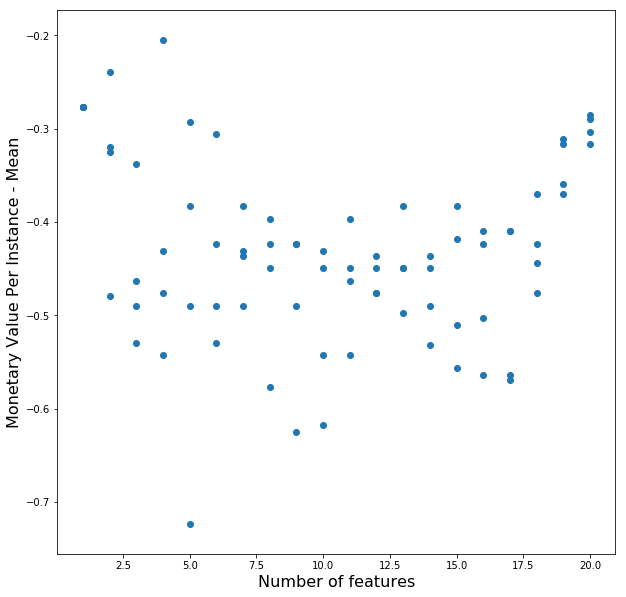

In [28]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [29]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)
['trustLevel' 'scannedLineItems' 'pricePerScannedLineItem'
 'quantityModificationsPerScannedLineItem']
{'learning_rate': 'optimal', 'loss': 'perceptron', 'penalty': 'l2'}


In [30]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1481
False positive:  294
False negative:  0
True positive:  104
-6830 for 1879 instances in the test set
-3.634912187333688 per instance in the test set
